In [2]:
## tools

from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper,ArxivAPIWrapper

In [3]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2,doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv,description="Query arxiv papers")
print(arxiv.name)

arxiv


In [4]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [5]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=2,doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name


'wikipedia'

In [6]:
wiki.invoke("shahrukh khan")

'Page: Shah Rukh Khan\nSummary: Shahrukh Khan (pronounced [ˈʃaːɦɾʊx xäːn] ; born 2 November 1965), and popularly known by the initials SRK, is an Indian actor and film producer renowned for his work in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appeared in more than 100 films, and earned numerous accolades, including a National Film Award and 15 Filmfare Awards. He has been awarded the Padma Shri by the Government of India, as well as the Order of'

In [7]:
import os
os.environ["GROQ_API_KEY"] = "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"
os.environ["TAVILY_API_KEY"]="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"

In [11]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

In [9]:
tavily.invoke("provide me the recent ai news"
              )

KeyboardInterrupt: 

In [10]:
## combine all these tools in the list
tools = [arxiv,wiki,tavily]

In [12]:
## initialize the LLm model

from langchain_groq import ChatGroq
llm = ChatGroq(model= "qwen/qwen3-32b")

In [14]:
response = llm.invoke("What is Ai")
print(response)

content='<think>\nOkay, the user is asking what AI is. Let me start by defining it simply. AI, or Artificial Intelligence, is the simulation of human intelligence in machines. But I need to go beyond that basic definition.\n\nFirst, mention the core areas like machine learning and deep learning. Maybe explain how machines can learn from data instead of just following strict programming. Include examples like image recognition or language processing to make it relatable.\n\nAlso, touch on different types of AI—narrow AI versus general AI. Most current systems are narrow, focused on specific tasks. General AI is still theoretical. Highlight real-world applications: virtual assistants, recommendation systems, autonomous vehicles. These examples show practical uses.\n\nDon\'t forget the history. Mention early concepts from the mid-20th century, like the Turing Test. Then move to modern advancements with big data and computing power. Maybe note key milestones, like IBM\'s Deep Blue or Alpha

In [13]:
llm_with_tools = llm.bind_tools(tools=tools)


In [21]:
## Execute this call

llm_with_tools.invoke("What is the recent news on ai")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent news on AI. I need to figure out which tool to use here. Let me check the available tools. There\'s arxiv, wikipedia, and tavily_search_results_json. \n\nArxiv is for academic papers, so maybe not the best choice for recent news. Wikipedia is good for general information but might not have the latest updates. The third option is tavily_search_results_json, which is described as a search engine optimized for current events. That sounds perfect for recent news.\n\nSo I should use tavily_search_results_json with the query "recent news on AI". Let me make sure the parameters are correct. The function requires a "query" parameter, which I\'ll set to "recent news on AI". No other parameters needed. \n\nI need to structure the tool call correctly. The name should be tavily_search_results_json and the arguments should be a JSON object with the query. Let me double-check the syntax. Yep, that shou

In [15]:
llm_with_tools.invoke("What is the latest research on quantum computing")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking about the latest research on quantum computing. I need to figure out which tool to use here. The available tools are arxiv, wikipedia, and tavily_search. \n\nArxiv is great for academic papers, so that\'s probably the best place to look for the latest research. Wikipedia might give general information but not the most recent studies. Tavily search is for current events, but quantum computing research is more likely to be found in academic databases.\n\nSo I should use the arxiv function. The parameter required is a query. The user\'s query is "latest research on quantum computing". I need to format that into the arxiv function call. The query parameter should be a string. Maybe I can use a keyword like "quantum computing" and add a date range to get the latest results. But the function\'s parameters don\'t mention date ranges. The description just says "search query to look up". So I\'ll stick with 

### Workflow

In [18]:
## State Schema
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage, HumanMessage  ## Human message or Ai message
from typing import Annotated ## Labelling
from langgraph.graph.message import add_messages ## REDUCERS IN lANGGRAPH


In [20]:
class State(TypedDict):
    messages: Annotated[list[AnyMessage],add_messages]


In [22]:
from IPython.display import Image, display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [23]:
def tool_calling_llm(state:State):
    return{"messages":[llm_with_tools.invoke(state["messages"])]}

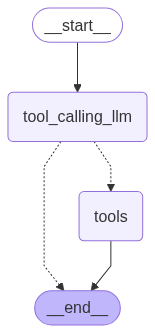

In [28]:
## Build graph

builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Edges
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call ->tools_condition routes to End
    tools_condition,
)
builder.add_edge("tools",END)
graph = builder.compile()

#view
display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
messages = graph.invoke({"messages": "1706.03762"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (whw2yzmbw)
 Call ID: whw2yzmbw
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base


In [30]:
messages = graph.invoke({"messages": "Hi i am ashish"})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hi i am ashish
================================== Ai Message ==================================

Hi Ashish! How can I assist you today?


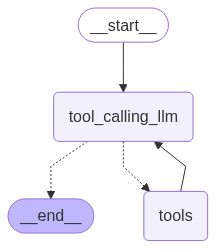

In [31]:
## Build graph

builder = StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

## Edges
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call ->tools_condition routes to End
    tools_condition,
)
builder.add_edge("tools","tool_calling_llm")
graph = builder.compile()

#view
display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
messages = graph.invoke({"messages": "what is recent ai news and please tell me about recent research on quantum computing"})
for m in messages['messages']:
    m.pretty_print()

APIConnectionError: Connection error.